Fernando Cerriteño Magaña A01702790

<h2>Parte 1

El conjunto de datos de criminalidad Download datos de criminalidadde Estados Unidos publicado en el año 1993 consiste de 51 registros para los que se tienen las siguientes variables:

* $VR$  = Crímenes violentos por cada 100000 habitantes
* $MR$  = Asesinatos por cada 100000 habitantes
* $M$   = Porcentaje de áreas metropolitanas
* $W$   = Porcentaje de gente blanca
* $H$   = Porcentaje de personas con preparatoria terminada
* $P$   = Porcentaje con ingresos por debajo del nivel de pobreza
* $S$   = Porcentaje de familias con solo un miembro adulto como tutor

In [ ]:
import numpy as np
import pandas as pd
import numpy.linalg
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, r_regression, SequentialFeatureSelector, RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import f_regression
from sklearn.neighbors import KNeighborsRegressor

Funciónes predictoras y de ajuste

In [ ]:
def predict(X, beta):
  return X @ beta

def fit_model(X, y):
  return np.linalg.inv(X.transpose() @ X) @ X.transpose() @ y

# Error function (it evaluates the mean squared error function for the specified model and data set).
def mse(X, y, beta):
  y_pred = X @ beta
  return (y - y_pred).sum()

# Gradient of error function (it evaluates the gradient of the mean squared error function for the specified model and data set).
def grad(X, y, beta, lambd):
  n = len(y)
  y_pred = X @ beta
  res = y - y_pred
  tmp = res*X.transpose()
  return -(2/n)*tmp.sum(axis = 1) + 2 *lambd*beta

# Fit model function (it fits a linear model using the specified data set).
def fit_model_Ridge(X, y, lambd=0.1, alpha = 0.0005, maxit = 100000):
  # Number of predictors
  npredictors = X.shape[1]

  # Initialize beta
  beta = 2*np.random.rand(npredictors) - 1.0

  # Optimization algorithm
  it = 0

  while (np.linalg.norm(grad(X, y, beta, lambd)) > 2e-4) and (it < maxit):
    beta = beta - alpha*grad(X, y, beta, lambd)
    it = it + 1

  return beta

In [ ]:
df = pd.read_csv('/content/crime_data.csv')

In [ ]:
df = df.drop(['State'],axis=1)
df = df.drop(['MR'],axis=1)
df = df.drop(['S'],axis=1)

In [ ]:
df.head()

,VR,M,W,H,P
0,761,41.8,75.2,86.6,9.1
1,780,67.4,73.5,66.9,17.4
2,593,44.7,82.9,66.3,20.0
3,715,84.7,88.6,78.7,15.4
4,1078,96.7,79.3,76.2,18.2


In [ ]:
df.isnull().sum()

VR    0
M     0
W     0
H     0
P     0
dtype: int64

In [ ]:
correlacion = df.corr()
alta_corr = np.where((correlacion>0.95)&(correlacion<1))
baja_corr = np.where((correlacion<-0.95)&(correlacion>-1))
if alta_corr[0].size == 0 and baja_corr[0].size == 0:
  print('Los datos no cuentan con correlación')
else:
  print('Los datos cuentan con correlación')

Los datos no cuentan con correlación


In [ ]:
df.head()

,VR,M,W,H,P
0,761,41.8,75.2,86.6,9.1
1,780,67.4,73.5,66.9,17.4
2,593,44.7,82.9,66.3,20.0
3,715,84.7,88.6,78.7,15.4
4,1078,96.7,79.3,76.2,18.2


Gráfica de las variables independientes contra la variable dependiente

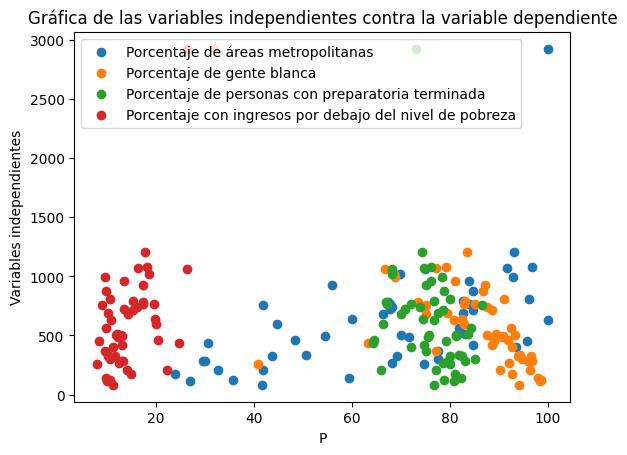

In [ ]:
columnas=['Porcentaje de áreas metropolitanas','Porcentaje de gente blanca','Porcentaje de personas con preparatoria terminada','Porcentaje con ingresos por debajo del nivel de pobreza']
for i in range(1,5):
  plt.scatter(df.iloc[:,i], df.iloc[:,0])
  plt.xlabel(df.columns[i])
  plt.ylabel('Variables independientes')
  plt.legend(columnas)
  # title=columnas[i],'vs',columnas[0]
  plt.grid()
  plt.title('Gráfica de las variables independientes contra la variable dependiente')
plt.show()

Obtención de los coeficientes de un modelo de regresión lineal por formula directa

In [ ]:
X = np.column_stack((np.ones(df.iloc[:,1].shape), df.iloc[:,1:]))
beta = np.linalg.inv(X.transpose() @ X) @ X.transpose() @ df.VR

In [ ]:
print("Coeficiente de intersección (β0):", beta[0])
for i, coef in enumerate(beta[1:], start=1):
    print(f"Coeficiente de β{i}: {coef}")

Coeficiente de intersección (β0): -2014.1247107147858
Coeficiente de β1: 9.094241163066735
Coeficiente de β2: -13.081500654727689
Coeficiente de β3: 29.020389388187134
Coeficiente de β4: 63.28190063796451


In [ ]:
y_pred = predict(X, beta)
y = df.VR
# Calculo de MSE, MAE y R^2 con el modelo de entrenamiento
print('MSE: ', mean_squared_error(y, y_pred))
print("MAE: ", mean_absolute_error(y, y_pred))
print("R^2: ", r2_score(y, y_pred))

MSE:  47045.06868763569
MAE:  165.2833108376553
R^2:  0.7533736206409568


Evaluación del modelo con validación cruzada k-folds

In [ ]:
n_folds = 21
kf = KFold(n_splits=n_folds, shuffle = True)

mse_cv = []
mae_cv = []
r2_cv = []

x = df.iloc[:,1:].to_numpy()
y = df.VR.to_numpy()

for train_index, test_index in kf.split(x):

    #Fase de entrenamiento
    x_train = x[train_index, :]
    y_train = y[train_index]

    beta_cv = fit_model(x_train, y_train)

    # Fase de prueba
    x_test = x[test_index, :]
    y_test = y[test_index]

    y_pred = predict(x_test, beta_cv)

    # Calculo de MSE, MAE y R^2
    mse_i = mean_squared_error(y_test, y_pred)
    mse_cv.append(mse_i)

    mae_i = mean_absolute_error(y_test, y_pred)
    mae_cv.append(mae_i)

    r2_i = r2_score(y_test, y_pred)
    r2_cv.append(r2_i)

print('MSE:', np.average(mse_cv), '  MAE:', np.average(mae_cv),'  R^2:', np.average(r2_cv))


MSE: 89159.14112445351   MAE: 173.40858699600233   R^2: -3.4377835291197663


Histograma de $R^2$ por metodo Monte Carlo

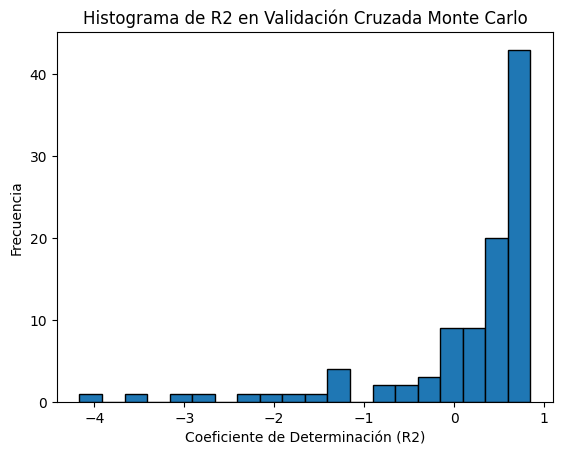

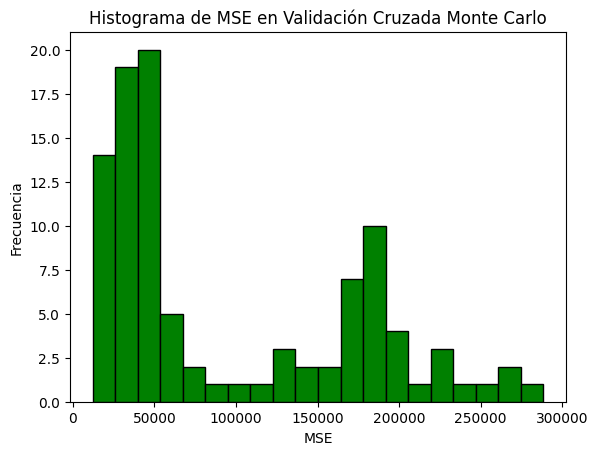

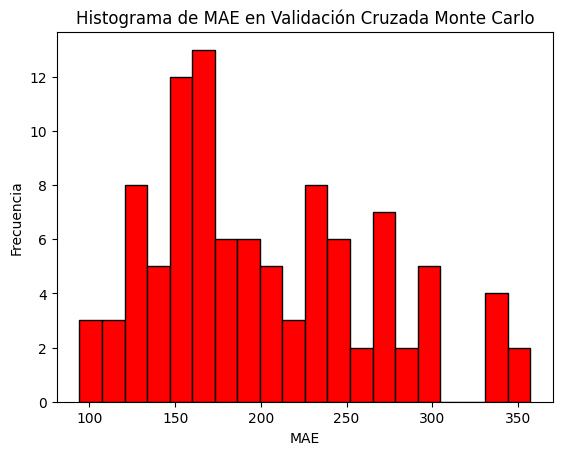

In [ ]:
# Generar datos de ejemplo
np.random.seed(42)
x = df.iloc[:,1:].to_numpy()
y = df.VR.to_numpy()

# Parámetros de la validación cruzada Monte Carlo
num_iterations = 100
test_size = 0.2

r2_scores = []
MSE_scores = []
MAE_scores = []

# Realizar la validación cruzada Monte Carlo
for _ in range(num_iterations):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2_MC = r2_score(y_test, y_pred)
    mse_MC = mean_squared_error(y_test, y_pred)
    mae_MC = mean_absolute_error(y_test, y_pred)
    r2_scores.append(r2_MC)
    MSE_scores.append(mse_MC)
    MAE_scores.append(mae_MC)

# Mostrar histogramas
plt.hist(r2_scores, bins=20, edgecolor='black')
plt.xlabel('Coeficiente de Determinación (R2)')
plt.ylabel('Frecuencia')
plt.title('Histograma de R2 en Validación Cruzada Monte Carlo')
plt.show()

plt.hist(MSE_scores, bins=20, edgecolor='black',color='green')
plt.xlabel('MSE')
plt.ylabel('Frecuencia')
plt.title('Histograma de MSE en Validación Cruzada Monte Carlo')
plt.show()

plt.hist(MAE_scores, bins=20, edgecolor='black',color='red')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')
plt.title('Histograma de MAE en Validación Cruzada Monte Carlo')
plt.show()

Adición de columnas que representen los cuadrados de las variables predictoras, así como los productos entre pares de variables

In [ ]:
df['M^2'] = df.M**2
df['W^2'] = df.W**2
df['H^2'] = df.H**2
df['P^2'] = df.P**2
df['MxW'] = df.M*df.W
df['MxH'] = df.M*df.H
df['MxP'] = df.M*df.P
df['WxH'] = df.W*df.H
df['WxP'] = df.W*df.P
df['HxP'] = df.H*df.P

In [ ]:
df.head()

,VR,M,W,H,P,M^2,W^2,H^2,P^2,MxW,MxH,MxP,WxH,WxP,HxP
0,761,41.8,75.2,86.6,9.1,1747.24,5655.04,7499.56,82.81,3143.36,3619.88,380.38,6512.32,684.32,788.06
1,780,67.4,73.5,66.9,17.4,4542.76,5402.25,4475.61,302.76,4953.90,4509.06,1172.76,4917.15,1278.90,1164.06
2,593,44.7,82.9,66.3,20.0,1998.09,6872.41,4395.69,400.00,3705.63,2963.61,894.00,5496.27,1658.00,1326.00
3,715,84.7,88.6,78.7,15.4,7174.09,7849.96,6193.69,237.16,7504.42,6665.89,1304.38,6972.82,1364.44,1211.98
4,1078,96.7,79.3,76.2,18.2,9350.89,6288.49,5806.44,331.24,7668.31,7368.54,1759.94,6042.66,1443.26,1386.84


Gráfica de las variables independientes contra la variable dependiente

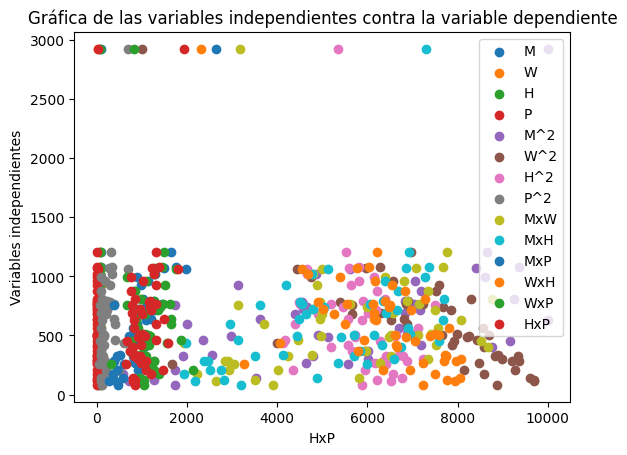

In [ ]:
for i in range(1,15):
  plt.scatter(df.iloc[:,i], df.iloc[:,0])
  plt.xlabel(df.columns[i])
  plt.legend(df.columns[1:])
  plt.ylabel('Variables independientes')
  plt.title('Gráfica de las variables independientes contra la variable dependiente')
  plt.grid()

Obtención de los coeficientes de un modelo de regresión lineal por formula directa

In [ ]:
X = np.column_stack((np.ones(df.iloc[:,1].shape), df.iloc[:,1:]))
beta = np.linalg.inv(X.transpose() @ X) @ X.transpose() @ df.VR
print("Coeficiente de intersección (β0):", beta[0])
for i, coef in enumerate(beta[1:], start=1):
    print(f"Coeficiente de β{i}: {coef}")

Coeficiente de intersección (β0): -44237.9959749628
Coeficiente de β1: 73.05981242170091
Coeficiente de β2: 315.4178289287905
Coeficiente de β3: 537.3753597314703
Coeficiente de β4: 1203.9790787276581
Coeficiente de β5: -0.038316006238021304
Coeficiente de β6: -0.4375140733040536
Coeficiente de β7: -1.2255563390933881
Coeficiente de β8: -9.490285720327362
Coeficiente de β9: -0.4395355469045994
Coeficiente de β10: -0.2577330304780111
Coeficiente de β11: -0.26722840274909987
Coeficiente de β12: -2.449539340419568
Coeficiente de β13: -3.586436949683706
Coeficiente de β14: -7.558797621704613


Evaluación del modelo con validación cruzada k-folds

In [ ]:
n_folds = 21
kf = KFold(n_splits=n_folds, shuffle = True)

mse_cv = []
mae_cv = []
r2_cv = []

x = df.iloc[:,1:].to_numpy()
y = df.VR.to_numpy()

for train_index, test_index in kf.split(x):

    #Fase de entrenamiento
    x_train = x[train_index, :]
    y_train = y[train_index]

    beta_cv = fit_model(x_train, y_train)

    # Fase de prueba
    x_test = x[test_index, :]
    y_test = y[test_index]

    y_pred = predict(x_test, beta_cv)

    # Calculo de MSE, MAE y R^2
    mse_i = mean_squared_error(y_test, y_pred)
    mse_cv.append(mse_i)

    mae_i = mean_absolute_error(y_test, y_pred)
    mae_cv.append(mae_i)

    r2_i = r2_score(y_test, y_pred)
    r2_cv.append(r2_i)

print('MSE:', np.average(mse_cv), '  MAE:', np.average(mae_cv),'  R^2:', np.average(r2_cv))


MSE: 226985.69184169688   MAE: 243.63587705588685   R^2: -5.938770765908844


Regresión Ridge con descenso de gradiente

In [ ]:
dfO = pd.read_csv('/content/crime_data.csv')
dfO = dfO.drop(['State'],axis=1)
dfO = dfO.drop(['MR'],axis=1)
dfO = dfO.drop(['S'],axis=1)
dfO.head()

,VR,M,W,H,P
0,761,41.8,75.2,86.6,9.1
1,780,67.4,73.5,66.9,17.4
2,593,44.7,82.9,66.3,20.0
3,715,84.7,88.6,78.7,15.4
4,1078,96.7,79.3,76.2,18.2


Parametros para Ridge y Lasso

In [ ]:
x = dfO.iloc[:,1:]
y = dfO.VR
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = 0.5, random_state = 1234,shuffle= True)

Ridge

In [ ]:
X = x.copy()
X.insert(loc=0, column='O', value=np.ones(df.iloc[:,1].shape))
y = df.VR
X = x.to_numpy()
y = y.to_numpy()

In [ ]:
coefs_R = []
alphas_R = np.logspace(-10, -6, 50)

#Ajuste del modelo Ridge
for alpha in alphas_R:
    beta = fit_model_Ridge(X, y, alpha=alpha)
    coefs_R.append(beta)

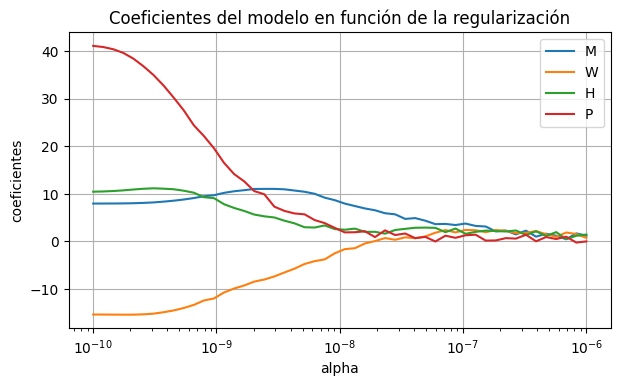

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas_R, coefs_R[::-1])
ax.legend(x.columns)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.grid()
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

Ridge con libreria sklearn

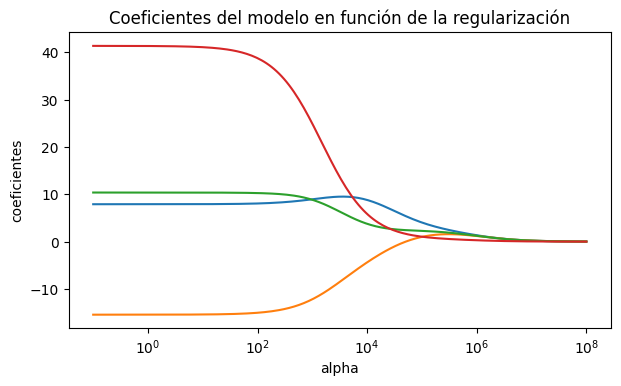

In [ ]:
#Ridge por sklearn
from sklearn.linear_model import RidgeCV, Ridge

alphas = np.logspace(-1, 8, 200)
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(x, y)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

Lasso

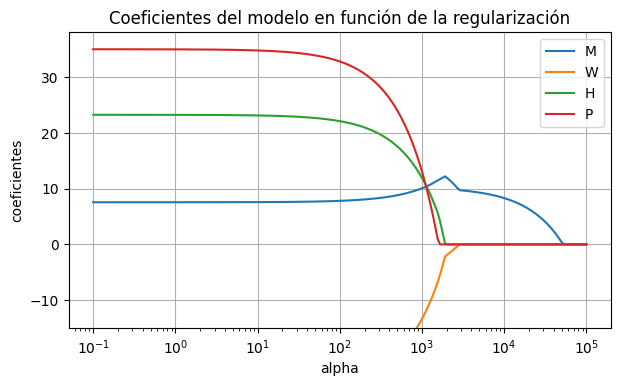

In [ ]:
modelo = LassoCV(alphas= np.logspace(-1,5,200),cv= 10)
_ = modelo.fit(X = x, y = y)

alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.grid()
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.legend(x.columns)
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');

In [ ]:
dfO[dfO.VR>1000]

,VR,M,W,H,P
4,1078,96.7,79.3,76.2,18.2
8,1206,93.0,83.5,74.4,17.8
17,1062,75.0,66.7,68.3,26.4
33,1074,91.7,77.2,74.8,16.4
39,1023,69.8,68.6,68.3,18.7
50,2922,100.0,31.8,73.1,26.4


In [ ]:
dfO[dfO.VR<250]

,VR,M,W,H,P
20,126,35.7,98.5,78.8,10.7
25,178,24.0,92.6,81.0,14.9
27,82,41.6,94.2,76.7,11.2
29,138,59.4,98.0,82.2,9.9
40,208,32.6,90.2,77.1,14.2
45,114,27.0,98.4,80.8,10.0
48,208,41.8,96.3,66.0,22.2


Viendo los resultados de regresión, desarrolla los siguientes puntos:
1.  ¿Consideras que el modelo de regresión lineal es efectivo para modelar los datos del problema? ¿Por qué?

**Creo que un modelo de regresión lineal podria funcionar pero tendria mucho error, esto debido a que al momento de obtener el valor del coeficiente de determinación $r^2$ por el metodo de validación cruzada, tiene un valor negativo cuando se calcula, aparte analizando los errores cuadraticos medio y absoluto se puede observar que estos se encuentran por encima de las triples cifras.**

2.  ¿Observas una variabilidad importante en los valores de R2, MSE y MAE cuando aplicas validación cruzada?

**Si, cuando se analiza el valor de $r^2$ con el modelo de entrenamiento nos da un valor positivo de 0.7, mientras que cuando se obtiene por el metodo de validación cruzada, el valor da siempre en los negativos variando normalmente desde -5 hasta -0.4**

3.  ¿Qué modelo es mejor para los datos de criminalidad, el lineal o el cuadrático? ¿Por qué?

**Creo que para estos datos es mejor una lineal, esto debido a que cuando se analizan la gráfica de disperción original se puede ver como la mayoria de las variables independientes tienden a seguir una recta, solo que los datos cuentan con mucha dispersión**


4.  ¿Qué variables son más relevantes para el modelo según Ride y Lasso?

**En ambos gráficos se puede observar que el valor del porcentaje de gente blanca (W) empieza siendo un valor negativo, representando que esta característica está contribuyendo negativamente a la predicción del modelo bajo el nivel de regularización específico, por lo tanto se puede asumir que las variables mas relevantes son el porcentaje de áreas metropolitanas (M), porcentaje de personas con preparatoria terminada (H) y porcentaje con ingresos por debajo del nivel de pobreza (P)**

5.  ¿Encuentras alguna relación interesante entre la variable de respuesta y los predictores?

**Analizando los valores del dataframe, se puede visualizar dos relaciones interesantes:**

1. **Los niveles de $VR$ son más elevados cuando el nivel de $M$ son altos.**
2. **Los niveles de $W$ son inversos a los valores de $VR$.**

**El segundo me hace confirmar lo establecido en la pregunta anterior, la variable $W$ no aporta mucho al modelo**

<h2>Parte 2

El conjunto de datos de esperanzas de vida (Life Expectancy (WHO)) tiene el registro de la esperanza de vida de 193 países medida en diferentes años, junto con otras variables que se pueden relacionar con riesgos a la salud y la mortalidad.

* X1 - Adult mortality
*X2 - Infant deaths
*X3 - Alcohol
*X4 - Percentage expenditure
*X5 - Hepatitis B
*X6 - Measles
*X7 - BMI
*X8 - Under-five deaths
*X9 - Polio
*X10 - Total expenditure
*X11 - Diphtheria
*X12 - HIV/AIDS   
*X13 - GDP
*X14 - Population
*X15 - Thinness  1-19 years
*X16 - Thinness 5-9 years
*X17 - Income composition of resources
*X18 - Schooling

In [ ]:
df = pd.read_csv('/content/life_expectancy_data.csv')

In [ ]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [ ]:
df = df.drop(['Hepatitis B'],axis = 1)
df = df.drop(['Polio'],axis = 1)
df = df.drop(['GDP'],axis = 1)
df = df.drop(['Income composition of resources'],axis = 1)

In [ ]:
df = df.rename(columns={' BMI ': "BMI", " HIV/AIDS": "HIV/AIDS","Life expectancy ":"Life_expectancy"," thinness  1-19 years":"thinness_1_19_years"," thinness 5-9 years":"thinness_5_9_years","Adult Mortality":"Adult_Mortality","infant deaths":"infant_deaths","percentage expenditure":"percentage_expenditure","under-five deaths ":"under_five_deaths","Total expenditure":"Total_expenditure"})

In [ ]:
df.describe()

,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Measles,BMI,under_five_deaths,Total_expenditure,Diphtheria,HIV/AIDS,Population,thinness_1_19_years,thinness_5_9_years,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2938.000000,2904.000000,2938.000000,2712.00000,2919.000000,2938.000000,2.286000e+03,2904.000000,2904.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,2419.592240,38.321247,42.035739,5.93819,82.324084,1.742103,1.275338e+07,4.839704,4.870317,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,11467.272489,20.044034,160.445548,2.49832,23.716912,5.077785,6.101210e+07,4.420195,4.508882,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,0.000000,1.000000,0.000000,0.37000,2.000000,0.100000,3.400000e+01,0.100000,0.100000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,0.000000,19.300000,0.000000,4.26000,78.000000,0.100000,1.957932e+05,1.600000,1.500000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,17.000000,43.500000,4.000000,5.75500,93.000000,0.100000,1.386542e+06,3.300000,3.300000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,360.250000,56.200000,28.000000,7.49250,97.000000,0.800000,7.420359e+06,7.200000,7.200000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,212183.000000,87.300000,2500.000000,17.60000,99.000000,50.600000,1.293859e+09,27.700000,28.600000,20.700000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 2938 non-null   object 
 1   Year                    2938 non-null   int64  
 2   Status                  2938 non-null   object 
 3   Life_expectancy         2928 non-null   float64
 4   Adult_Mortality         2928 non-null   float64
 5   infant_deaths           2938 non-null   int64  
 6   Alcohol                 2744 non-null   float64
 7   percentage_expenditure  2938 non-null   float64
 8   Measles                 2938 non-null   int64  
 9   BMI                     2904 non-null   float64
 10  under_five_deaths       2938 non-null   int64  
 11  Total_expenditure       2712 non-null   float64
 12  Diphtheria              2919 non-null   float64
 13  HIV/AIDS                2938 non-null   float64
 14  Population              2286 non-null   

Preparación de los datos para su uso

In [ ]:
df = df.astype({"Country":'category'})
df = df.astype({"Status":'category'})

In [ ]:
df.isnull().sum()

Country                     0
Year                        0
Status                      0
Life_expectancy            10
Adult_Mortality            10
infant_deaths               0
Alcohol                   194
percentage_expenditure      0
Measles                     0
BMI                        34
under_five_deaths           0
Total_expenditure         226
Diphtheria                 19
HIV/AIDS                    0
Population                652
thinness_1_19_years        34
thinness_5_9_years         34
Schooling                 163
dtype: int64

Relleno de los valores nulos con un backward fill

In [ ]:
df = df.bfill()  # backward fill

In [ ]:
df.isnull().sum()

Country                   0
Year                      0
Status                    0
Life_expectancy           0
Adult_Mortality           0
infant_deaths             0
Alcohol                   0
percentage_expenditure    0
Measles                   0
BMI                       0
under_five_deaths         0
Total_expenditure         0
Diphtheria                0
HIV/AIDS                  0
Population                0
thinness_1_19_years       0
thinness_5_9_years        0
Schooling                 0
dtype: int64

In [ ]:
first_column = df.pop('Life_expectancy')
df.insert(0, 'Life_expectancy', first_column)

In [ ]:
df['Country'] = df['Country'].str.replace(' ', '_', regex=True)

In [ ]:
y = df.Life_expectancy
x = df.iloc[:,1:]

x = x.drop(['Country'],axis = 1)
x = x.drop(['Status'],axis = 1)

In [ ]:
# Convert to arrays
x = x.to_numpy()
y = y.to_numpy()

Validación cruzada por k-folds en regresión lineal

In [ ]:
num_folds = 5
kf = KFold(n_splits=num_folds)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE: ', mse)
print("MAE: ", mae)
print("R^2: ", r2)

MSE:  16.191718427289324
MAE:  2.954640609405385
R^2:  0.813277811832735


Obtención del numero optimo de predictores usando filter y validación cruzada

MSE: 49.13915109923574   MAE: 5.095350999838998   R^2: 0.45577949434638027
MSE: 42.404045102618774   MAE: 4.803799947628843   R^2: 0.5316484895090848
MSE: 38.2523332655589   MAE: 4.60546363701974   R^2: 0.5769127817784069
MSE: 38.287355945686755   MAE: 4.621056689604563   R^2: 0.5764809159916636
MSE: 36.85916601519138   MAE: 4.551584708336823   R^2: 0.5901091122044999
MSE: 36.77732401052793   MAE: 4.542990264458248   R^2: 0.5927560364118809
MSE: 36.81414715241471   MAE: 4.550087792713289   R^2: 0.5925010817349217
MSE: 36.786383669918294   MAE: 4.5459246780326215   R^2: 0.5914932976915568
MSE: 36.78402465306253   MAE: 4.548533861259822   R^2: 0.5917251791963513


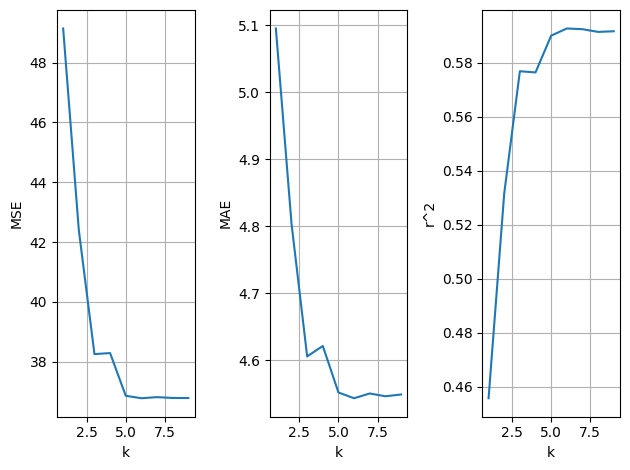

In [ ]:
# Find optimal number of features using cross-validation
n_feats = list(range(1,10))

mse_nfeat = []
mae_nfeat = []
r2_nfeat = []

for n_feat in n_feats:
    # print('---- n features =', n_feat)

    mse_cv = []
    mae_cv = []
    r2_cv = []

    kf = KFold(n_splits=5, shuffle = True)

    for train_index, test_index in kf.split(x):

        # Training phase
        x_train = x[train_index, :]
        y_train = y[train_index]

        fselection_cv = SelectKBest(r_regression, k = n_feat)
        fselection_cv.fit(x_train, y_train)
        x_train = fselection_cv.transform(x_train)

        regr_cv = linear_model.LinearRegression()
        regr_cv.fit(x_train, y_train)

        # Test phase
        x_test = fselection_cv.transform(x[test_index, :])
        y_test = y[test_index]
        y_pred = regr_cv.predict(x_test)

        mse_i = mean_squared_error(y_test, y_pred)
        mse_cv.append(mse_i)

        mae_i = mean_absolute_error(y_test, y_pred)
        mae_cv.append(mae_i)

        r2_i = r2_score(y_test, y_pred)
        r2_cv.append(r2_i)


    mse = np.average(mse_cv)
    mse_nfeat.append(mse)

    mae = np.average(mae_cv)
    mae_nfeat.append(mae)

    r2 = np.average(r2_cv)
    r2_nfeat.append(r2)

    print('MSE:', mse, '  MAE:', mae,'  R^2:', r2)

fig, axs = plt.subplots(1, 3, tight_layout=True)
axs[0].plot(n_feats, mse_nfeat)
axs[0].set_xlabel("k")
axs[0].set_ylabel("MSE")
axs[0].grid()

axs[1].plot(n_feats, mae_nfeat)
axs[1].set_xlabel("k")
axs[1].set_ylabel("MAE")
axs[1].grid()

axs[2].plot(n_feats, r2_nfeat)
axs[2].set_xlabel("k")
axs[2].set_ylabel("r^2")
axs[2].grid()

plt.show()

Analizando las gráficas, se puede argumentar que el numero optimo de predictores es 5, esto es debido a que obtuvo uno de los resultados más bajos tanto en el MSE como en MAE, tambien cuenta con un $r^2$ elevado a comparación de los otros números de predictores

Selección de características secuencial Metodo Wrapper

MSE: 46.73817255396463   MAE: 4.814066366584323   R^2: 0.4819022329356466
MSE: 30.177853319527543   MAE: 3.737053037341311   R^2: 0.6659756233008928
MSE: 25.524481166863637   MAE: 3.5322633891977473   R^2: 0.7175522085659187
MSE: 22.546242936801896   MAE: 3.412921251890533   R^2: 0.7504626992736544
MSE: 20.99707463547191   MAE: 3.3634193552795635   R^2: 0.767973507349541
MSE: 20.070777216313818   MAE: 3.308158949211453   R^2: 0.7779500668480974
MSE: 19.982177218571664   MAE: 3.3124830437873625   R^2: 0.7792453990114669
MSE: 19.608767884960017   MAE: 3.2900854126765147   R^2: 0.7832575970758955


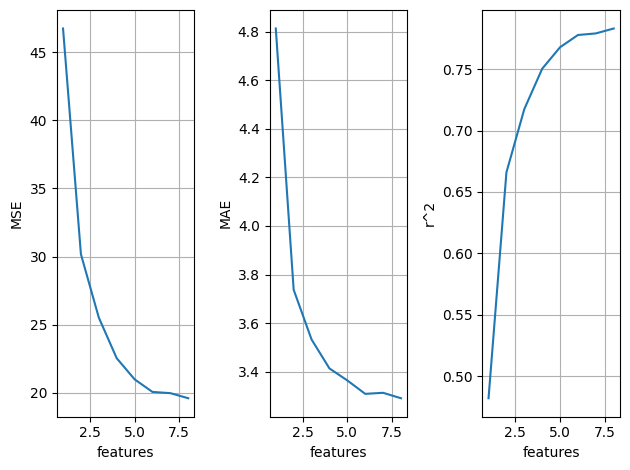

In [ ]:
# Find optimal number of features using cross-validation
n_feats = list(range(1,9))

mse_nfeat = []
mae_nfeat = []
r2_nfeat = []
for n_feat in n_feats:
    # print('---- n features =', n_feat)

    mse_cv = []
    mae_cv = []
    r2_cv = []

    kf = KFold(n_splits=5, shuffle = True)

    for train_index, test_index in kf.split(x):

        # Training phase
        x_train = x[train_index, :]
        y_train = y[train_index]

        regr_cv = linear_model.LinearRegression()

        fselection_cv = SequentialFeatureSelector(regr_cv, n_features_to_select=n_feat)
        fselection_cv.fit(x_train, y_train)
        x_train = fselection_cv.transform(x_train)

        regr_cv.fit(x_train, y_train)

        # Test phase
        x_test = fselection_cv.transform(x[test_index, :])
        y_test = y[test_index]
        y_pred = regr_cv.predict(x_test)

        mse_i = mean_squared_error(y_test, y_pred)
        mse_cv.append(mse_i)

        mae_i = mean_absolute_error(y_test, y_pred)
        mae_cv.append(mae_i)

        r2_i = r2_score(y_test, y_pred)
        r2_cv.append(r2_i)


    mse = np.average(mse_cv)
    mse_nfeat.append(mse)

    mae = np.average(mae_cv)
    mae_nfeat.append(mae)

    r2 = np.average(r2_cv)
    r2_nfeat.append(r2)

    print('MSE:', mse, '  MAE:', mae,'  R^2:', r2)

fig, axs = plt.subplots(1, 3, tight_layout=True)
axs[0].plot(n_feats, mse_nfeat)
axs[0].set_xlabel("features")
axs[0].set_ylabel("MSE")
axs[0].grid()

axs[1].plot(n_feats, mae_nfeat)
axs[1].set_xlabel("features")
axs[1].set_ylabel("MAE")
axs[1].grid()

axs[2].plot(n_feats, r2_nfeat)
axs[2].set_xlabel("features")
axs[2].set_ylabel("r^2")
axs[2].grid()

plt.show()

Analizando las gráficas se puede arguumentar que el número optimo de parametros es 6, esto es debido a que en el MSE, a partir de este número de parametros, la gráfica no nota una mejora considerable, en el MAE, despues de usar 6 parametros, la gráfica se vuelve estatica, indicando que no existe mejora considerable y finalmente en la gráfica de $r^2$, con este número de parametros, se obtiene un valor aceptable siendo de los más altos en la gráfica.

Método de selección de características recursivo (Filter-Wrapper).

MSE: 49.0139361875991   MAE: 5.0874785481731175   R^2: 0.45785265981830925
MSE: 33.028921885002944   MAE: 4.140583946611963   R^2: 0.6340715454958704
MSE: 31.74848084627638   MAE: 4.1132434348988   R^2: 0.649320140098334
MSE: 30.885386572463155   MAE: 4.119032542445078   R^2: 0.6577180404432228
MSE: 31.25298871126271   MAE: 4.14003564250533   R^2: 0.6537148970799362
MSE: 28.936171842989392   MAE: 4.040176831701731   R^2: 0.6803250450195663
MSE: 27.046399939442313   MAE: 3.908478183370989   R^2: 0.700355757841
MSE: 24.80349879018932   MAE: 3.7715320413420192   R^2: 0.7255118997546897
MSE: 24.359117031997553   MAE: 3.739457402467589   R^2: 0.7296222584758179
MSE: 23.755208343842064   MAE: 3.6632042768177504   R^2: 0.736456302705222
MSE: 21.378435100767355   MAE: 3.4503680419405534   R^2: 0.762803866127544
MSE: 19.260894999268167   MAE: 3.260734239738281   R^2: 0.7870870134008994
MSE: 18.42807618370998   MAE: 3.1995215043742715   R^2: 0.7961917632193497
MSE: 18.503189000314016   MAE: 3.20

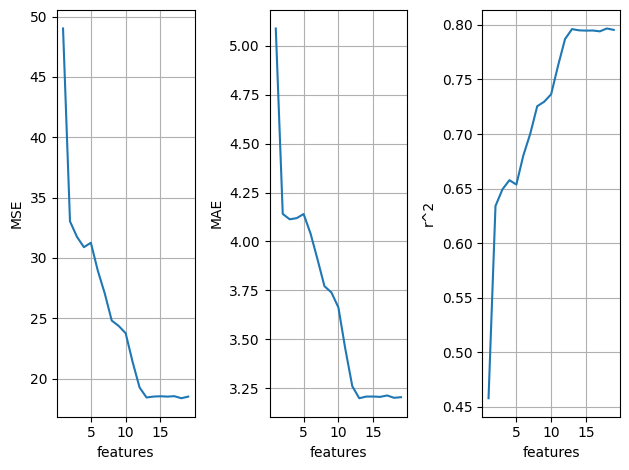

In [ ]:
# Find optimal number of features using cross-validation
n_feats = list(range(1,20))

mse_nfeat = []
mae_nfeat = []
r2_nfeat = []
for n_feat in n_feats:
    # print('---- n features =', n_feat)
    mse_cv = []
    mae_cv = []
    r2_cv = []

    kf = KFold(n_splits=5, shuffle = True)

    for train_index, test_index in kf.split(x):

        # Training phase
        x_train = x[train_index, :]
        y_train = y[train_index]

        regr_cv = linear_model.LinearRegression()

        fselection_cv = RFE(regr_cv, n_features_to_select=n_feat)
        fselection_cv.fit(x_train, y_train)
        x_train = fselection_cv.transform(x_train)

        regr_cv.fit(x_train, y_train)

        # Test phase
        x_test = fselection_cv.transform(x[test_index, :])
        y_test = y[test_index]
        y_pred = regr_cv.predict(x_test)

        mse_i = mean_squared_error(y_test, y_pred)
        mse_cv.append(mse_i)

        mae_i = mean_absolute_error(y_test, y_pred)
        mae_cv.append(mae_i)

        r2_i = r2_score(y_test, y_pred)
        r2_cv.append(r2_i)


    mse = np.average(mse_cv)
    mse_nfeat.append(mse)

    mae = np.average(mae_cv)
    mae_nfeat.append(mae)

    r2 = np.average(r2_cv)
    r2_nfeat.append(r2)

    print('MSE:', mse, '  MAE:', mae,'  R^2:', r2)

fig, axs = plt.subplots(1, 3, tight_layout=True)
axs[0].plot(n_feats, mse_nfeat)
axs[0].set_xlabel("features")
axs[0].set_ylabel("MSE")
axs[0].grid()

axs[1].plot(n_feats, mae_nfeat)
axs[1].set_xlabel("features")
axs[1].set_ylabel("MAE")
axs[1].grid()

axs[2].plot(n_feats, r2_nfeat)
axs[2].set_xlabel("features")
axs[2].set_ylabel("r^2")
axs[2].grid()

plt.show()

Analizando la gráfica se puede ver como tuvo una mejora considerable despues de haber estado con el mismo si no es que peor desempeño, no obstante cuando llega a aproximadamente 13 parametros es cuando se puede notar que ya no cuenta con una mejora, contando asi con un MSE y un MAE bajo y un $r^2$ aceptable

Filter, Wrapper y Filter-Wrapper con el modelo de regresión no lineal K-vecinos más cercanos.

Filter

MSE: 23.884511754684837   MAE: 2.845553662691652   R^2: 0.7314153037492274
MSE: 10.554314139693357   MAE: 2.1527086882453155   R^2: 0.8813152520570676
MSE: 7.215182964224872   MAE: 1.9760477001703578   R^2: 0.918864252083362
MSE: 7.834891311754686   MAE: 1.9718228279386714   R^2: 0.9118955444959977
MSE: 9.718077683134583   MAE: 1.946201022146507   R^2: 0.8907188487052012
MSE: 8.920286882453153   MAE: 1.906678023850085   R^2: 0.8996901185420507
MSE: 8.733485519591142   MAE: 1.8674616695059623   R^2: 0.9017907261583518
MSE: 8.02233049403748   MAE: 1.7542759795570695   R^2: 0.9097877645105416
MSE: 13.62179625212947   MAE: 2.2688245315161844   R^2: 0.8468209839771798
MSE: 15.26466507666099   MAE: 2.382350936967632   R^2: 0.8283466928236203
MSE: 15.289986371379898   MAE: 2.381226575809199   R^2: 0.8280619513007201
MSE: 15.074101533219762   MAE: 2.371856899488927   R^2: 0.8304896066900338
MSE: 14.961315161839863   MAE: 2.353458262350937   R^2: 0.831757905310053
MSE: 30.387108006814305   MAE:

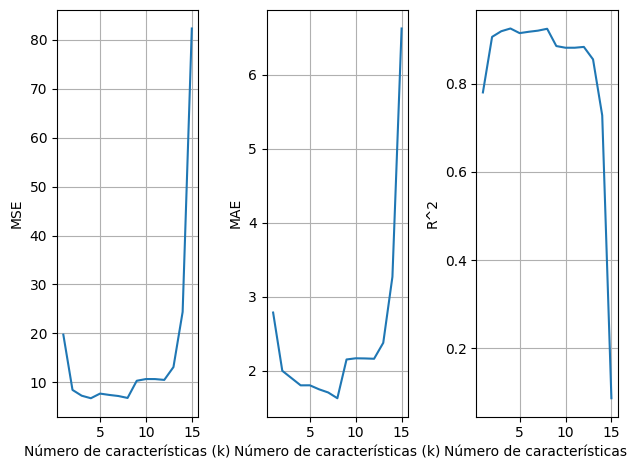

In [ ]:
selector = SelectKBest(f_regression)

k_values = np.arange(1, x.shape[1] + 1)

mse_nfeat = {}
mae_nfeat = {}
r2_nfeat = {}

for n_feat in k_values:
    mse_cv = []
    mae_cv = []
    r2_cv = []

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(x):
        # Training phase
        x_train = x[train_index, :]
        y_train = y[train_index]

        fselection_cv = SelectKBest(f_regression, k=n_feat)
        fselection_cv.fit(x_train, y_train)
        x_train = fselection_cv.transform(x_train)

        regr_cv = KNeighborsRegressor(n_neighbors=5)
        regr_cv.fit(x_train, y_train)

        # Test phase
        x_test = fselection_cv.transform(x[test_index, :])
        y_test = y[test_index]
        y_pred = regr_cv.predict(x_test)

        mse_i = mean_squared_error(y_test, y_pred)
        mse_cv.append(mse_i)

        mae_i = mean_absolute_error(y_test, y_pred)
        mae_cv.append(mae_i)

        r2_i = r2_score(y_test, y_pred)
        r2_cv.append(r2_i)

    mse_nfeat[n_feat] = np.average(mse_cv)
    mae_nfeat[n_feat] = np.average(mae_cv)
    r2_nfeat[n_feat] = np.average(r2_cv)
    print('MSE:', mse_i, '  MAE:', mae_i,'  R^2:', r2_i)

# Graficar los resultados
fig, axs = plt.subplots(1, 3, tight_layout=True)
axs[0].plot(k_values, list(mse_nfeat.values()))
axs[0].set_xlabel("Número de características (k)")
axs[0].set_ylabel("MSE")
axs[0].grid()

axs[1].plot(k_values, list(mae_nfeat.values()))
axs[1].set_xlabel("Número de características (k)")
axs[1].set_ylabel("MAE")
axs[1].grid()

axs[2].plot(k_values, list(r2_nfeat.values()))
axs[2].set_xlabel("Número de características (k)")
axs[2].set_ylabel("R^2")
axs[2].grid()

plt.tight_layout()
plt.show()

Wrapper

MSE: 19.742620580143473   MAE: 2.7875033897715813   R^2: 0.7803606021739754
MSE: 8.432943253021822   MAE: 2.0009777376027076   R^2: 0.9064539358867426
MSE: 7.2526827760201185   MAE: 1.9025432789810988   R^2: 0.9192593662223147
MSE: 6.880741115321769   MAE: 1.7555601640997114   R^2: 0.9234071596563446
MSE: 6.4988450004056135   MAE: 1.6637961965024508   R^2: 0.9277134340614838
MSE: 5.755556351330993   MAE: 1.59079458563664   R^2: 0.9361525153047058
MSE: 5.659071141628713   MAE: 1.5566778268377195   R^2: 0.9373723640222641
MSE: 5.570988271737998   MAE: 1.5450499716070414   R^2: 0.9383476954158029
MSE: 6.649366164632805   MAE: 1.5841052625479493   R^2: 0.9264050870456687


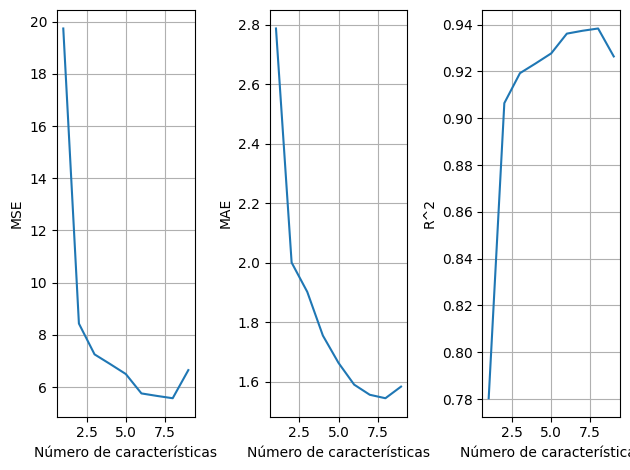

In [ ]:
n_feats = list(range(1,10))

mse_nfeat = []
mae_nfeat = []
r2_nfeat = []

for n_feat in n_feats:
    # print('---- n features =', n_feat)

    mse_cv = []
    mae_cv = []
    r2_cv = []

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(x):

        # Training phase
        x_train = x[train_index, :]
        y_train = y[train_index]

        regr_cv = KNeighborsRegressor(n_neighbors=5)

        fselection_cv = SequentialFeatureSelector(regr_cv, n_features_to_select=n_feat)
        fselection_cv.fit(x_train, y_train)
        x_train = fselection_cv.transform(x_train)

        regr_cv.fit(x_train, y_train)

        # Test phase
        x_test = fselection_cv.transform(x[test_index, :])
        y_test = y[test_index]
        y_pred = regr_cv.predict(x_test)

        mse_i = mean_squared_error(y_test, y_pred)
        mse_cv.append(mse_i)

        mae_i = mean_absolute_error(y_test, y_pred)
        mae_cv.append(mae_i)

        r2_i = r2_score(y_test, y_pred)
        r2_cv.append(r2_i)


    mse = np.average(mse_cv)
    mse_nfeat.append(mse)

    mae = np.average(mae_cv)
    mae_nfeat.append(mae)

    r2 = np.average(r2_cv)
    r2_nfeat.append(r2)

    print('MSE:', mse, '  MAE:', mae,'  R^2:', r2)

fig, axs = plt.subplots(1, 3, tight_layout=True)
axs[0].plot(n_feats, mse_nfeat)
axs[0].set_xlabel("Número de características")
axs[0].set_ylabel("MSE")
axs[0].grid()

axs[1].plot(n_feats, mae_nfeat)
axs[1].set_xlabel("Número de características")
axs[1].set_ylabel("MAE")
axs[1].grid()


axs[2].plot(n_feats, r2_nfeat)
axs[2].set_xlabel("Número de características")
axs[2].set_ylabel("R^2")
axs[2].grid()

plt.tight_layout()
plt.show()

Filter-Wrapper

Debido a que no se pudo realizar el metodo Filter Wrapper con RFE en k vecinos cercanos se dicidio hacerlo con maquinas de soporte vextorial, no obstante hacerlo de esta forma requiere de mucho tiempo, por lo que no se pudo ejecutar de forma correcta, por lo tanto se decidio dejar esta sección comentada.

In [ ]:
# from sklearn.svm import SVR

# n_feats = list(range(1, 10))

# mse_nfeat = []
# mae_nfeat = []
# r2_nfeat = []

# for n_feat in n_feats:
#     mse_cv = []
#     mae_cv = []
#     r2_cv = []

#     kf = KFold(n_splits=5, shuffle=True, random_state=42)

#     for train_index, test_index in kf.split(x):
#         # Training phase
#         x_train = x[train_index, :]
#         y_train = y[train_index]

#         regr_cv = KNeighborsRegressor(n_neighbors=5)

#         estimator = SVR(kernel="linear")
#         fselection_cv = RFE(estimator, n_features_to_select=n_feat, step=1)
#         fselection_cv.fit(x_train, y_train)
#         x_train_selected = fselection_cv.transform(x_train)

#         regr_cv.fit(x_train_selected, y_train)

#         # Test phase
#         x_test_selected = selector.transform(x[test_index, :])
#         y_test = y[test_index]
#         y_pred = regr_cv.predict(x_test_selected)

#         mse_i = mean_squared_error(y_test, y_pred)
#         mse_cv.append(mse_i)

#         mae_i = mean_absolute_error(y_test, y_pred)
#         mae_cv.append(mae_i)

#         r2_i = r2_score(y_test, y_pred)
#         r2_cv.append(r2_i)

#     mse = np.average(mse_cv)
#     mse_nfeat.append(mse)

#     mae = np.average(mae_cv)
#     mae_nfeat.append(mae)

#     r2 = np.average(r2_cv)
#     r2_nfeat.append(r2)
#     print('MSE:', mse, '  MAE:', mae,'  R^2:', r2)

# fig, axs = plt.subplots(1, 3, tight_layout=True)
# axs[0].plot(n_feats, mse_nfeat)
# axs[0].set_xlabel("Número de características")
# axs[0].set_ylabel("MSE")
# axs[0].grid()

# axs[1].plot(n_feats, mae_nfeat)
# axs[1].set_xlabel("Número de características")
# axs[1].set_ylabel("MAE")
# axs[1].grid()

# axs[2].plot(n_feats, r2_nfeat)
# axs[2].set_xlabel("Número de características")
# axs[2].set_ylabel("R^2")
# axs[2].grid()

# plt.tight_layout()
# plt.show()

Árbol de decisión para generar un modelo de regresión

In [ ]:
y = df.iloc[:,0]
x = df.iloc[:,1:]

In [ ]:
x = x.drop(['Country'],axis = 1)

In [ ]:
x = pd.get_dummies(x, columns=['Status'], drop_first=True)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
reg_tree = DecisionTreeRegressor(random_state=42)

In [ ]:
# Entrenamiento del modelo
reg_tree.fit(x_train, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
y_pred = reg_tree.predict(x_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

Mean Squared Error: 6.181105442176871
Mean Absolute Error: 1.4392857142857143
R^2 Score: 0.9287197625972382


In [ ]:
# Realizar validación cruzada y evaluar el modelo utilizando R^2
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = cross_val_score(reg_tree, x, y, cv=kf, scoring='r2')
y_pred = cross_val_predict(reg_tree, x, y, cv=kf)

# Imprimir los resultados de la validación cruzada
print("Coeficientes R^2 en cada fold:", r2_scores)
print("R^2 promedio:", r2_scores.mean())

mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Coeficientes R^2 en cada fold: [0.92871976 0.92172158 0.91850255 0.93020576 0.9116381 ]
R^2 promedio: 0.9221575497733856
Mean Squared Error (MSE): 7.034509870660313
Mean Absolute Error (MAE): 1.576140231449966


1. Consideras que el modelo de regresión lineal es adecuado para los datos.

**Mientras que un modelo de regrsión lineal funciona con los datos, considero que un modelo de regresión no lineal podria funcionar mejor, debido a que cuando se analiza el MSE y el MAE con un modelo de regresión no lineal, los valores obtenidos son más bajo que cuando se analiza con un modelo de regresión lineal.**

2. ¿Qué método de selección de características consideras que funciona bien con los datos? ¿Por qué?

**Considero que el metodo filter puede ser un buen candidato para seleccionar las caracteristicas, esto es debido a que en regresión lineal obtuvo buenos datos con un el numero de caracteristicas más pequeño en comparación con los otros metodos.**

3. Del proceso de selección de características, ¿puedes identificar algunas que sean sobresalientes?

**Las características mas sobresalientes fue cuando se evaluaron 9 caracteristicas en el metodo de Wrapper, opino que resulta interesante debido a que se puede observar como es que tanto el MSE y el MAE empiezan a aumentar mientras que el $r^2$ empieza a disminuir**

4. ¿El modelo de regresión no lineal funcionó mejor que el lineal?

**Como se menciono antes, el modelo no lineal presento mejores resultados en la obtención de MSE, MAE y de $r^2$, en la obtención de caracteristicas, se observa como de forma similar, los valores son mejores a los vistos en cada una de las caracteristicas de regresión lineal**

5. ¿Notas alguna mejora con el árbol de decisión al agregar la variable categórica "Status"?

**Usando el árbol de desición definitivamente se puede apreciar una mejora en los tres aspectos evaluados (MSE, MAE, $r^2$) a comparación de regresión lineal**

6. ¿Se puede concluir algo interesante sobre los resultados de modelar estos datos con regresión?

**Analizando los resultados observados en las gráficas obtenidas, me hace llegar a la conclución que se cuentan con varias variables que no aportan mucho al modelo, aparte de que se puede notar observaciones claras entre algunos datos observados en la tabla, como la mortalidad adulta con la esperanza de vida o la relación entre la esperanza de vida y el porcentaje de gastos**